In [73]:
!pip install openai pandas utils scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 26.2 MB/s eta 0:00:00


In [81]:
import os
import pandas as df

In [103]:
# os.environ['OPENAI_API_KEY'] = ''
# os.environ['GPT_MODEL'] = 'gpt-3.5-turbo'

In [104]:
os.environ["OPENAI_API_BASE"] = "http://fc-api-server:8000/v1"
os.environ["OPENAI_API_KEY"] = "EMPTY"

In [105]:
import pandas as pd
import tiktoken


In [106]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [107]:
input_datapath = "fine_food_reviews_1k.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [90]:
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [101]:
df

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.036636363714933395, -0.023187169805169106, ..."
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07047566026449203, -0.031760234385728836, ..."
296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[0.05685221776366234, -0.005375450011342764, 0..."
295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.011264046654105186, -0.049711164087057114,..."
294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[0.05692615360021591, -0.005402443464845419, 0..."
...,...,...,...,...,...,...,...,...
623,B0000CFXYA,A3GS4GWPIBV0NT,1,Strange inflammation response,Truthfully wasn't crazy about the taste of the...,Title: Strange inflammation response; Content:...,110,"[-0.04797293618321419, 0.04624166339635849, 0...."
624,B0001BH5YM,A1BZ3HMAKK0NC,5,My favorite and only MUSTARD,You've just got to experience this mustard... ...,Title: My favorite and only MUSTARD; Content:...,80,"[0.026543840765953064, -0.027481311932206154, ..."
625,B0009ET7TC,A2FSDQY5AI6TNX,5,My furbabies LOVE these!,Shake the container and they come running. Eve...,Title: My furbabies LOVE these!; Content: Shak...,47,"[-0.010999701917171478, -0.029047295451164246,..."
619,B007PA32L2,A15FF2P7RPKH6G,5,got this for the daughter,all i have heard since she got a kuerig is why...,Title: got this for the daughter; Content: all...,50,"[-0.005805113818496466, 0.0211869478225708, -0..."


In [92]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))

In [93]:
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

In [108]:
query = 'Which athletes won the gold medal in curling at the 2022 Winter Olympics?'

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about the 2022 Winter Olympics.'},
        {'role': 'user', 'content': query},
    ],
    model="gpt-3.5-turbo",
    temperature=0,
)

print(response.choices[0].message.content)

The Swedish team won the gold medal in the men's curling event at the 2022 Winter Olympics. The Swiss team won the gold medal in the women's curling event.


In [109]:
GPT_MODEL="gpt-3.5-turbo"

In [110]:
wikipedia_article_on_curling = """Curling at the 2022 Winter Olympics

Article
Talk
Read
Edit
View history
From Wikipedia, the free encyclopedia
Curling
at the XXIV Olympic Winter Games
Curling pictogram.svg
Curling pictogram
Venue	Beijing National Aquatics Centre
Dates	2–20 February 2022
No. of events	3 (1 men, 1 women, 1 mixed)
Competitors	114 from 14 nations
← 20182026 →
Men's curling
at the XXIV Olympic Winter Games
Medalists
1st place, gold medalist(s)		 Sweden
2nd place, silver medalist(s)		 Great Britain
3rd place, bronze medalist(s)		 Canada
Women's curling
at the XXIV Olympic Winter Games
Medalists
1st place, gold medalist(s)		 Great Britain
2nd place, silver medalist(s)		 Japan
3rd place, bronze medalist(s)		 Sweden
Mixed doubles's curling
at the XXIV Olympic Winter Games
Medalists
1st place, gold medalist(s)		 Italy
2nd place, silver medalist(s)		 Norway
3rd place, bronze medalist(s)		 Sweden
Curling at the
2022 Winter Olympics
Curling pictogram.svg
Qualification
Statistics
Tournament
Men
Women
Mixed doubles
vte
The curling competitions of the 2022 Winter Olympics were held at the Beijing National Aquatics Centre, one of the Olympic Green venues. Curling competitions were scheduled for every day of the games, from February 2 to February 20.[1] This was the eighth time that curling was part of the Olympic program.

In each of the men's, women's, and mixed doubles competitions, 10 nations competed. The mixed doubles competition was expanded for its second appearance in the Olympics.[2] A total of 120 quota spots (60 per sex) were distributed to the sport of curling, an increase of four from the 2018 Winter Olympics.[3] A total of 3 events were contested, one for men, one for women, and one mixed.[4]

Qualification
Main article: Curling at the 2022 Winter Olympics – Qualification
Qualification to the Men's and Women's curling tournaments at the Winter Olympics was determined through two methods (in addition to the host nation). Nations qualified teams by placing in the top six at the 2021 World Curling Championships. Teams could also qualify through Olympic qualification events which were held in 2021. Six nations qualified via World Championship qualification placement, while three nations qualified through qualification events. In men's and women's play, a host will be selected for the Olympic Qualification Event (OQE). They would be joined by the teams which competed at the 2021 World Championships but did not qualify for the Olympics, and two qualifiers from the Pre-Olympic Qualification Event (Pre-OQE). The Pre-OQE was open to all member associations.[5]

For the mixed doubles competition in 2022, the tournament field was expanded from eight competitor nations to ten.[2] The top seven ranked teams at the 2021 World Mixed Doubles Curling Championship qualified, along with two teams from the Olympic Qualification Event (OQE) – Mixed Doubles. This OQE was open to a nominated host and the fifteen nations with the highest qualification points not already qualified to the Olympics. As the host nation, China qualified teams automatically, thus making a total of ten teams per event in the curling tournaments.[6]

Summary
Nations	Men	Women	Mixed doubles	Athletes
 Australia			Yes	2
 Canada	Yes	Yes	Yes	12
 China	Yes	Yes	Yes	12
 Czech Republic			Yes	2
 Denmark	Yes	Yes		10
 Great Britain	Yes	Yes	Yes	10
 Italy	Yes		Yes	6
 Japan		Yes		5
 Norway	Yes		Yes	6
 ROC	Yes	Yes		10
 South Korea		Yes		5
 Sweden	Yes	Yes	Yes	11
 Switzerland	Yes	Yes	Yes	12
 United States	Yes	Yes	Yes	11
Total: 14 NOCs	10	10	10	114
Competition schedule

The Beijing National Aquatics Centre served as the venue of the curling competitions.
Curling competitions started two days before the Opening Ceremony and finished on the last day of the games, meaning the sport was the only one to have had a competition every day of the games. The following was the competition schedule for the curling competitions:

RR	Round robin	SF	Semifinals	B	3rd place play-off	F	Final
Date
Event
Wed 2	Thu 3	Fri 4	Sat 5	Sun 6	Mon 7	Tue 8	Wed 9	Thu 10	Fri 11	Sat 12	Sun 13	Mon 14	Tue 15	Wed 16	Thu 17	Fri 18	Sat 19	Sun 20
Men's tournament								RR	RR	RR	RR	RR	RR	RR	RR	RR	SF	B	F	
Women's tournament									RR	RR	RR	RR	RR	RR	RR	RR	SF	B	F
Mixed doubles	RR	RR	RR	RR	RR	RR	SF	B	F												
Medal summary
Medal table
Rank	Nation	Gold	Silver	Bronze	Total
1	 Great Britain	1	1	0	2
2	 Sweden	1	0	2	3
3	 Italy	1	0	0	1
4	 Japan	0	1	0	1
 Norway	0	1	0	1
6	 Canada	0	0	1	1
Totals (6 entries)	3	3	3	9
Medalists
Event	Gold	Silver	Bronze
Men
details	 Sweden
Niklas Edin
Oskar Eriksson
Rasmus Wranå
Christoffer Sundgren
Daniel Magnusson	 Great Britain
Bruce Mouat
Grant Hardie
Bobby Lammie
Hammy McMillan Jr.
Ross Whyte	 Canada
Brad Gushue
Mark Nichols
Brett Gallant
Geoff Walker
Marc Kennedy
Women
details	 Great Britain
Eve Muirhead
Vicky Wright
Jennifer Dodds
Hailey Duff
Mili Smith	 Japan
Satsuki Fujisawa
Chinami Yoshida
Yumi Suzuki
Yurika Yoshida
Kotomi Ishizaki	 Sweden
Anna Hasselborg
Sara McManus
Agnes Knochenhauer
Sofia Mabergs
Johanna Heldin
Mixed doubles
details	 Italy
Stefania Constantini
Amos Mosaner	 Norway
Kristin Skaslien
Magnus Nedregotten	 Sweden
Almida de Val
Oskar Eriksson
Teams
Men
 Canada	 China	 Denmark	 Great Britain	 Italy
Skip: Brad Gushue
Third: Mark Nichols
Second: Brett Gallant
Lead: Geoff Walker
Alternate: Marc Kennedy

Skip: Ma Xiuyue
Third: Zou Qiang
Second: Wang Zhiyu
Lead: Xu Jingtao
Alternate: Jiang Dongxu

Skip: Mikkel Krause
Third: Mads Nørgård
Second: Henrik Holtermann
Lead: Kasper Wiksten
Alternate: Tobias Thune

Skip: Bruce Mouat
Third: Grant Hardie
Second: Bobby Lammie
Lead: Hammy McMillan Jr.
Alternate: Ross Whyte

Skip: Joël Retornaz
Third: Amos Mosaner
Second: Sebastiano Arman
Lead: Simone Gonin
Alternate: Mattia Giovanella

 Norway	 ROC	 Sweden	 Switzerland	 United States
Skip: Steffen Walstad
Third: Torger Nergård
Second: Markus Høiberg
Lead: Magnus Vågberg
Alternate: Magnus Nedregotten

Skip: Sergey Glukhov
Third: Evgeny Klimov
Second: Dmitry Mironov
Lead: Anton Kalalb
Alternate: Daniil Goriachev

Skip: Niklas Edin
Third: Oskar Eriksson
Second: Rasmus Wranå
Lead: Christoffer Sundgren
Alternate: Daniel Magnusson

Fourth: Benoît Schwarz
Third: Sven Michel
Skip: Peter de Cruz
Lead: Valentin Tanner
Alternate: Pablo Lachat

Skip: John Shuster
Third: Chris Plys
Second: Matt Hamilton
Lead: John Landsteiner
Alternate: Colin Hufman

Women
 Canada	 China	 Denmark	 Great Britain	 Japan
Skip: Jennifer Jones
Third: Kaitlyn Lawes
Second: Jocelyn Peterman
Lead: Dawn McEwen
Alternate: Lisa Weagle

Skip: Han Yu
Third: Wang Rui
Second: Dong Ziqi
Lead: Zhang Lijun
Alternate: Jiang Xindi

Skip: Madeleine Dupont
Third: Mathilde Halse
Second: Denise Dupont
Lead: My Larsen
Alternate: Jasmin Lander

Skip: Eve Muirhead
Third: Vicky Wright
Second: Jennifer Dodds
Lead: Hailey Duff
Alternate: Mili Smith

Skip: Satsuki Fujisawa
Third: Chinami Yoshida
Second: Yumi Suzuki
Lead: Yurika Yoshida
Alternate: Kotomi Ishizaki

 ROC	 South Korea	 Sweden	 Switzerland	 United States
Skip: Alina Kovaleva
Third: Yulia Portunova
Second: Galina Arsenkina
Lead: Ekaterina Kuzmina
Alternate: Maria Komarova

Skip: Kim Eun-jung
Third: Kim Kyeong-ae
Second: Kim Cho-hi
Lead: Kim Seon-yeong
Alternate: Kim Yeong-mi

Skip: Anna Hasselborg
Third: Sara McManus
Second: Agnes Knochenhauer
Lead: Sofia Mabergs
Alternate: Johanna Heldin

Fourth: Alina Pätz
Skip: Silvana Tirinzoni
Second: Esther Neuenschwander
Lead: Melanie Barbezat
Alternate: Carole Howald

Skip: Tabitha Peterson
Third: Nina Roth
Second: Becca Hamilton
Lead: Tara Peterson
Alternate: Aileen Geving

Mixed doubles
 Australia	 Canada	 China	 Czech Republic	 Great Britain
Female: Tahli Gill
Male: Dean Hewitt

Female: Rachel Homan
Male: John Morris

Female: Fan Suyuan
Male: Ling Zhi

Female: Zuzana Paulová
Male: Tomáš Paul

Female: Jennifer Dodds
Male: Bruce Mouat

 Italy	 Norway	 Sweden	 Switzerland	 United States
Female: Stefania Constantini
Male: Amos Mosaner

Female: Kristin Skaslien
Male: Magnus Nedregotten

Female: Almida de Val
Male: Oskar Eriksson

Female: Jenny Perret
Male: Martin Rios

Female: Vicky Persinger
Male: Chris Plys
"""

In [111]:
query = f"""Use the below article on the 2022 Winter Olympics to answer the subsequent question. If the answer cannot be found, write "I don't know."

Article:
\"\"\"
{wikipedia_article_on_curling}
\"\"\"

Question: Which athletes won the gold medal in curling at the 2022 Winter Olympics?"""

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about the 2022 Winter Olympics.'},
        {'role': 'user', 'content': query},
    ],
    model=GPT_MODEL,
    temperature=0,
)

print(response.choices[0].message.content)

The athletes who won the gold medal in curling at the 2022 Winter Olympics were as follows:

- Men's Curling: Sweden's team consisting of Niklas Edin, Oskar Eriksson, Rasmus Wranå, Christoffer Sundgren, and Daniel Magnusson.
- Women's Curling: Great Britain's team consisting of Eve Muirhead, Vicky Wright, Jennifer Dodds, Hailey Duff, and Mili Smith.
- Mixed Doubles Curling: Italy's team consisting of Stefania Constantini and Amos Mosaner.


In [67]:
# Text search using embeddings

In [63]:
import numpy as np
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        model="text-embedding-3-small"
    )
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results


results = search_reviews(df, "delicious beans", n=3)

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning

Fantastic Instant Refried beans:  Fantastic Instant Refried Beans have been a staple for my family now for nearly 20 years.  All 7 of us love it and my grown kids are passing on the tradition.

Delicious:  While there may be better coffee beans available, this is my first purchase and my first time grinding my own beans.  I read several reviews before purchasing this brand, and am extremely 



In [70]:
search_reviews(df, "tuna fish", n=4)

These also have SALT and it's not sea salt.:  I like the fact that you can see what you're getting and that there are no bones or dark meat.  There are 7 nice big chunks in every jar.<br /><br />These

Fantastic Flavor! Great for Tuna Steaks!!:  Why would someone pay almost $15 for this product (although the taste is worth it)when you can get it for less. Check your prices before paying too much.

Very tasty and good for you!:  I have always loved this product and was glad to subscribe so that I could have a constant supply on hand.  The smoky flavor and the lower salt content are very tasty.  

Great Salmon:  This Salmon Is The Best!  I Try To Make A Small Variety Of Salmon Dishes, But For Me, Salmon Patties As Nice As My Mother Used To Make Is My Favorite!



3      These also have SALT and it's not sea salt.:  ...
471    Fantastic Flavor! Great for Tuna Steaks!!:  Wh...
344    Very tasty and good for you!:  I have always l...
558    Great Salmon:  This Salmon Is The Best!  I Try...
Name: combined, dtype: object

KeyError: 'code'

In [74]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# Load the embeddings
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(literal_eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

Text(0.5, 1.0, 'Visualization of the Embedding')

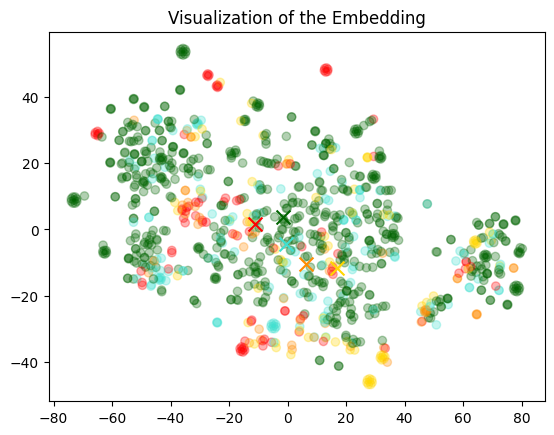

In [80]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Visualization of the Embedding")

ValueError: could not convert string to float: '[-0.07287187874317169, -0.0025306211318820715, -0.0463707372546196, -0.03781229630112648, -0.007100753486156464, -0.035510025918483734, 0.015315106138586998, 0.009740857407450676, 0.04849783331155777, -0.014676976017653942, 0.013350668363273144, -0.06816723197698593, -0.001726703136228025, 0.013200519606471062, 0.01868092641234398, 0.06956861913204193, -0.0004144713166169822, -0.020194917917251587, -0.02807769365608692, 0.01750476472079754, 0.05029961094260216, 0.027702324092388153, -0.03626076504588127, 0.05255183205008507, 0.007745139300823212, -0.0018299298826605082, -0.014314118772745132, 0.03641091287136078, 0.01709185726940632, -0.015515303239226341, -0.055404648184776306, -0.016954222694039345, -0.009008885361254215, -0.06871777772903442, -0.01890614815056324, -0.013475791551172733, 0.04922354966402054, 0.0034158690832555294, 0.025287441909313202, -0.03948894888162613, 0.004936118610203266, 0.05170099437236786, 0.011192289181053638, 0.004426240921020508, 0.01735461689531803, 0.02962922491133213, 0.035960469394922256, 0.023022707551717758, 7.365663623204455e-05, -0.019043782725930214, -0.04406846687197685, 0.03045503795146942, 0.009027654305100441, -0.026626262813806534, 0.0011159444693475962, -0.05087517946958542, -0.006475136615335941, 0.029203804209828377, -0.010285144671797752, 0.04126570001244545, 0.012937760911881924, -0.009415537118911743, -0.022121818736195564, -0.005223902408033609, 0.016503777354955673, -0.06976881623268127, -0.01973196305334568, -0.014939735643565655, 0.03095553256571293, 0.0030999325681477785, -0.02572537399828434, -0.011436279863119125, -0.027527151629328728, -0.024374041706323624, 0.011955542489886284, 0.021959159523248672, 0.03523475304245949, -0.04572009667754173, 0.03293248265981674, 0.007501148618757725, -0.00295760459266603, 0.038362838327884674, -0.05760682001709938, 0.0053146169520914555, 0.016729000955820084, -0.05215143784880638, -0.04484423249959946, -0.017692450433969498, 0.006106022745370865, 0.02772734872996807, 0.00891504343599081, -0.03996441885828972, -0.0004570914607029408, 0.01859333924949169, 0.008520903997123241, 0.02820281684398651, -0.06531441956758499, 0.014927223324775696, -0.03220676630735397, -0.0023476281203329563, 0.029604200273752213, -0.01770496368408203, 0.00106667703948915, 0.012743819504976273, 0.038237713277339935, -0.029954545199871063, -0.01084819994866848, -0.006381294224411249, 0.0157029889523983, -0.0001893469161586836, 0.0163661427795887, 0.02359827607870102, -0.054603856056928635, 0.049023352563381195, 0.006381294224411249, -0.018230481073260307, 0.022084282711148262, -0.022684874013066292, -0.01576554961502552, 0.005230158567428589, -0.013838649727404118, 0.02099570818245411, -0.03566017374396324, -0.03318272903561592, -0.009108984842896461, 0.00830819457769394, 0.03998944163322449, 0.030279865488409996, -0.01011622790247202, -0.057556770741939545, 0.022084282711148262, 0.023861035704612732, 0.011974310502409935, -0.026150792837142944, -0.03460913524031639, 0.04229171201586723, -0.04742177203297615, 0.044268663972616196, 0.010954555124044418, 0.023560738191008568, -0.008483367040753365, -0.04421861469745636, 0.032306864857673645, 0.02582547254860401, 0.005959002301096916, -0.026726361364126205, -0.04449388384819031, -0.010091203264892101, 0.020307529717683792, 0.032807357609272, -0.012518597766757011, 0.01820545643568039, -0.02483699657022953, -0.027702324092388153, 0.024574238806962967, -0.06986891478300095, -0.05075005441904068, -0.007720114663243294, -0.0341336652636528, 0.015728013589978218, 0.023610787466168404, -0.008414549753069878, 0.00022639517555944622, 0.007263414096087217, 0.0032375683076679707, 0.03168124705553055, -0.024624288082122803, 0.007989129982888699, -0.06346259266138077, -0.054954204708337784, 0.025074731558561325, 0.008696077391505241, 0.04939872398972511, -0.01659136451780796, -0.03485938161611557, -0.018293043598532677, -0.01855580136179924, -0.07802695780992508, -0.02620084211230278, -0.03510962799191475, 0.017267031595110893, 0.05890810117125511, -0.00047038582852110267, -0.06801708787679672, -0.01039149984717369, 0.0006158418254926801, -0.012662488967180252, 0.01338820531964302, 0.015602889470756054, -0.007401050068438053, 0.002319475170224905, 0.011154752224683762, 0.0022788101341575384, -0.037887368351221085, -0.02512478083372116, -0.030980557203292847, 0.00981593132019043, -0.03658608719706535, 0.03215671703219414, 0.0444188117980957, -0.017079345881938934, 0.001327090198174119, 0.036335840821266174, -0.02725187875330448, -0.03180637210607529, -0.03556007519364357, -0.005108163226395845, -0.013325643725693226, -0.025925571098923683, 0.009528147988021374, 0.014664463698863983, 0.0187434870749712, 0.015377667732536793, 0.06556466966867447, -0.01818043179810047, 0.002966988831758499, -0.02531246654689312, 0.044869255274534225, 0.024824485182762146, 0.004160353448241949, 0.00172513909637928, -0.020795511081814766, 0.01944417878985405, 0.012143227271735668, -0.015315106138586998, -0.017154419794678688, -0.03035493940114975, -0.04086530581116676, -0.020845560356974602, 0.003985180519521236, 0.01696673408150673, 0.03938885033130646, -0.03556007519364357, 0.033132679760456085, -0.002931016031652689, 0.03663613647222519, 0.038938406854867935, -0.007632527966052294, 0.012800125405192375, -0.020282505080103874, 0.016378654167056084, -8.352965232916176e-05, -0.0008813380263745785, 0.0051832376047968864, 0.009765882045030594, -0.006825482007116079, -0.01458938978612423, -0.037411902099847794, -0.0347592830657959, -0.01564042642712593, -0.015052346512675285, 0.02962922491133213, 0.020057283341884613, -0.019969696179032326, 0.014314118772745132, 0.0069068125449121, -0.003465918591246009, 0.015215006656944752, -0.023210393264889717, -0.026701336726546288, -0.03903850540518761, 0.07942834496498108, 0.00723213329911232, 0.03843791410326958, -0.06971876323223114, 0.052701979875564575, 0.030905483290553093, 0.01839314214885235, 0.02347315289080143, 0.003591042011976242, 0.0033001299016177654, -0.024086257442831993, 0.011361205950379372, 0.023072756826877594, 0.00934046320617199, -0.007119521964341402, -0.023097781464457512, 0.010347706265747547, 0.03285740688443184, 0.0533025749027729, -0.0872860923409462, -0.04919852688908577, 0.009321694262325764, -0.02452418953180313, -0.002479007700458169, 0.004144712816923857, 0.05205133929848671, -0.01116726454347372, -0.01167401485145092, -0.01671648770570755, -0.020657874643802643, -0.0187434870749712, 0.03973919525742531, 0.03498450666666031, 0.0476970449090004, -0.019369104877114296, 0.009922286495566368, -0.00999110471457243, 0.004129072651267052, 0.015452741645276546, 0.040840283036231995, -0.0022553494200110435, 0.07782676070928574, -0.006963117979466915, 0.03626076504588127, 0.01677905023097992, -0.002815276850014925, -0.03530982881784439, -0.05965884402394295, 0.00690055638551712, -0.016854124143719673, 0.04331772401928902, 0.012074409052729607, -0.012487316504120827, -0.002142738550901413, -0.06131047382950783, 0.008458342403173447, 0.01011622790247202, 0.016291068866848946, -0.016391167417168617, 0.0112611074000597, -0.0204576775431633, 0.027176804840564728, 0.004460649564862251, -0.02289758436381817, 0.001216825214214623, -0.03808756545186043, 0.012312144041061401, 0.00701942341402173, 0.028478087857365608, -0.026125768199563026, 0.010491598397493362, -0.03355810046195984, 0.010266375727951527, -0.02020743116736412, 0.006071613635867834, 0.06186101585626602, -0.004341782536357641, 0.0005028397426940501, 0.01833057962357998, -0.031481049954891205, -0.00875238236039877, 0.0008359808125533164, 0.011561403051018715, -0.02394862100481987, -0.023047732189297676, 0.012481060810387135, -0.003844416933134198, 0.007826469838619232, 0.025400053709745407, -0.03603554144501686, 0.0029841933865100145, -0.015265055932104588, -0.017554813995957375, 0.05225153639912605, 0.03766214847564697, -0.0043073734268546104, 0.00554296700283885, 0.017742499709129333, -0.000875081866979599, 0.018468216061592102, 0.03393346816301346, -0.04624561220407486, 0.02179649844765663, 0.005511686205863953, 0.023498177528381348, 0.018117869272828102, -0.04884818196296692, -0.023560738191008568, -0.027176804840564728, -0.014063871465623379, 0.002294450532644987, -0.03961407393217087, -0.023097781464457512, -0.06236150860786438, -0.009378000162541866, -0.01833057962357998, 0.04046491160988808, -0.04199141636490822, 0.004551364108920097, 0.028878483921289444, -0.05052483454346657, -0.02493709698319435, -0.02940400131046772, 0.051851142197847366, -0.004563876427710056, -0.0013693193905055523, 0.0029341441113501787, -0.02411128208041191, 0.01540269237011671, -0.00147723825648427, 0.0012723486870527267, -0.00785149447619915, -0.02439906634390354, 0.006118535064160824, 0.01487717404961586, 0.01054790336638689, -0.025925571098923683, -0.02299768291413784, -0.022259455174207687, 0.0015304157277569175, 0.012274607084691525, -0.02822784148156643, 0.026751386001706123, 0.01236844900995493, 0.020219944417476654, 0.01737964153289795, 0.0030623956117779016, 0.008145534433424473, 0.041315749287605286, -0.03500952944159508, -0.018318068236112595, 0.026476114988327026, 0.01457687746733427, 8.230774255935103e-05, -0.03653603792190552, 0.006065357476472855, 0.03843791410326958, 0.028052669018507004, 0.023673349991440773, -0.0028121487703174353, -0.010716820135712624, -0.02677641063928604, -0.0066440533846616745, -0.023873547092080116, 0.059909090399742126, 0.002131790155544877, -0.04299240559339523, -0.008020410314202309, -0.02987947128713131, -0.0654645711183548, 0.018793536350131035, -0.01824299432337284, -0.03448401391506195, 0.0076638092286884785, -0.04189131781458855, -0.049724042415618896, 0.014364168047904968, -0.017492253333330154, -0.03746195137500763, 0.0013317823177203536, -0.011824162676930428, -0.03083040937781334, -0.009190314449369907, -0.05054985731840134, -0.0107543570920825, 0.05180109292268753, 0.025099756196141243, -0.03733682632446289, -0.04994926601648331, -0.06481392681598663, -0.03783731907606125, -0.03450903668999672, 0.012937760911881924, 0.005893312860280275, 0.020057283341884613, -0.036936432123184204, -0.014827124774456024, -0.011311156675219536, -0.03240696340799332, 0.032907456159591675, 0.02078299969434738, -0.018918659538030624, 0.006956861820071936, -0.0032532087061554193, 0.03518470376729965, -0.05390316620469093, 0.05560484528541565, 0.018067819997668266, -0.03876323252916336, -0.04159102216362953, 0.0014756742166355252, -0.037862345576286316, -0.00027722655795514584, -0.030029619112610817, -0.06086002662777901, -0.012962785549461842, 0.02064536325633526, -0.03150607645511627, 0.028478087857365608, 0.03651101142168045, 0.015340130776166916, -0.00361606664955616, 0.03375829756259918, -0.028878483921289444, 0.018793536350131035, -0.02458675019443035, -0.0045013148337602615, -0.050800107419490814, 0.0607098788022995, -0.0012653105659410357, -0.05370296910405159, -0.021396104246377945, -0.011298644356429577, -0.042867280542850494, 0.00456074858084321, 0.020607825368642807, -0.02074546180665493, -0.009778394363820553, -0.010998347774147987, -0.0065439543686807156, -0.014802100136876106, 0.00854592863470316, 0.02016989327967167, -0.021859060972929, 0.0064125750213861465, -0.027126755565404892, -0.041440874338150024, 0.011824162676930428, 0.0026010030414909124, -0.03838786482810974, 0.018505752086639404, 0.03270725905895233, -0.01886861026287079, 0.01966940052807331, 0.03821269050240517, -0.011886724270880222, 0.012624952010810375, -0.011742832139134407, 0.03138095140457153, -0.02496212162077427, 0.02207176946103573, -0.03310765326023102, -0.009753369726240635, -0.010247607715427876, -0.0055335829965770245, 0.0027402027044445276, 0.016979247331619263, -0.025750398635864258, -0.02347315289080143, 0.06791698932647705, 0.030054643750190735, 0.010109972208738327, 0.04627063870429993, 0.01564042642712593, 0.011342437006533146, -0.047121476382017136, 0.013350668363273144, 0.022509701550006866, 0.01052913535386324, 0.032807357609272, -0.019994720816612244, 0.040264714509248734, 0.001992590259760618, 0.024499164894223213, -0.02725187875330448, 0.050424735993146896, 0.0029826294630765915, 0.003688012482598424, 0.04824758693575859, 0.018856098875403404, -0.00608099764212966, -0.0033439232502132654, -0.026250891387462616, 0.032306864857673645, -0.00690055638551712, 0.01405135914683342, -0.018217969685792923, -0.032056618481874466, -0.003126521361991763, 0.01659136451780796, -0.010572928003966808, -0.0083770127967, -0.005320873111486435, 0.006794201210141182, -0.020182406529784203, -0.027777398005127907, 0.014601902104914188, -0.032181743532419205, 0.019406640902161598, -0.027326952666044235, -0.01818043179810047, 0.021859060972929, -0.01931905560195446, 0.011999335139989853, -0.0037505743093788624, 0.047121476382017136, 0.009146521799266338, -0.04969901964068413, 0.0019206444267183542, 0.0015718628419563174, -0.025900546461343765, -0.0017595479730516672, 0.02655118890106678, -0.05295222997665405, 0.017692450433969498, 0.0696687176823616, -0.0018268018029630184, 0.014239043928682804, 0.03493445739150047, -0.034684211015701294, -0.019681911915540695, -0.014101408421993256, 0.009528147988021374, 0.022284479811787605, -0.014376680366694927, 0.0017001143423840404, 0.024286454543471336, -0.005877672228962183, 0.010935786180198193, 0.018117869272828102, -0.03095553256571293, -0.01223081350326538, -0.015602889470756054, 0.003991436678916216, 0.032532088458538055, -0.013901211321353912, 0.014614414423704147, -0.005580504424870014, -0.01655382663011551, 0.006196736823767424, 0.05795716494321823, 0.028027644380927086, -0.028828434646129608, -0.022084282711148262, 0.01681658625602722, 0.02454921416938305, -0.03898845613002777, -0.0023961132392287254, 0.0003722421533893794, -0.03048006258904934, -0.025800447911024094, 0.033858396112918854, -0.00517072482034564, 0.004563876427710056, 0.005758805200457573, -0.022259455174207687, -0.0009016706026159227, 0.03450903668999672, 0.020507726818323135, 0.029328927397727966, 0.006794201210141182, 0.05510435253381729, 0.011304900050163269, -0.01642870344221592, -0.0008844661060720682, 0.026976607739925385, -0.061210375279188156, -0.009446817450225353, -0.020307529717683792, -0.03438391536474228, 0.02902863174676895, 0.03058016300201416, -0.029378976672887802, 0.01338820531964302, -0.0348343588411808, 0.011336181312799454, -0.005327129270881414, -0.007569966372102499, -0.01770496368408203, 0.006619028747081757, -0.01760486327111721, 0.04544482380151749, -0.022972658276557922, -0.0037255496717989445, 0.029929520562291145, 0.007870262488722801, -0.002586926566436887, 0.028603212907910347, -0.010935786180198193, 0.025775423273444176, -0.0018705950351431966, -0.020607825368642807, -0.0211208313703537, 0.02690153382718563, 0.02822784148156643, 0.0006134957075119019, -0.025425078347325325, -0.0034127410035580397, 0.0016625773860141635, 0.043092504143714905, -0.050574883818626404, -0.02760222554206848, 0.011605196632444859, 0.03641091287136078, 0.01446426659822464, -0.0065564666874706745, -0.014664463698863983, -0.03190647065639496, -0.002036383608356118, -0.00840829312801361, -0.0238485224545002, -0.008370756171643734, 0.04056501016020775, 0.02020743116736412, 0.022447140887379646, -0.005811982322484255, 0.02264733798801899, 0.012349680997431278, 0.004438753239810467, 0.006384422071278095, -0.007745139300823212, 0.03393346816301346, 0.01236844900995493, -0.001820545643568039, 0.028828434646129608, -0.007463611662387848, 0.025324977934360504, -0.012925248593091965, -0.06035953387618065, -0.00859597884118557, 0.0017220110166817904, 0.0167540255934, 0.021708911284804344, -0.013062884099781513, 0.003478430910035968, 0.01276884414255619, 0.015302593819797039, -0.010935786180198193, -0.002655744319781661, 0.005392819177359343, -0.003095240332186222, -0.057306524366140366, 0.034809332340955734, 0.01554032787680626, 0.01634111814200878, 0.011486329138278961, 0.025575226172804832, -0.01665392704308033, -0.0059996675699949265, 0.018580825999379158, 0.03648598864674568, -0.030605187639594078, -0.011874211952090263, 0.01966940052807331, -0.025174830108880997, 0.039313774555921555, -0.012812637723982334, 0.031706273555755615, 0.031606175005435944, -0.011930517852306366, 0.02607571892440319, 0.002005102578550577, -0.01158017199486494, -0.016603877767920494, -0.00041486232657916844, 0.028753360733389854, 0.00935923121869564, 0.019456690177321434, -0.03283238410949707, 0.006575235165655613, -0.023235417902469635, 0.013087908737361431, -0.02245965227484703, 0.0041509694419801235, 0.0029732449911534786, 0.0444188117980957, -0.018005259335041046, -0.00537717854604125, -0.026275916025042534, -0.04164107143878937, 0.010422780178487301, -0.005902696866542101, 0.04554492235183716, -0.005492917727679014, -0.02822784148156643, -0.02087058499455452, -0.0016328605124726892, 0.008827457204461098, 0.006725383456796408, 0.04336777329444885, 0.038813281804323196, -0.00263228383846581, -0.015465253964066505, -0.028127742931246758, 0.0031124448869377375, 0.016378654167056084, -0.005761933047324419, 0.007476123981177807, -0.009916030801832676, -0.008952580392360687, 0.005317745264619589, 0.008702333085238934, 0.017654914408922195, 0.0491735003888607, 0.003475302830338478, 0.01498978491872549, 0.02099570818245411, 0.00701942341402173, 0.03153109923005104, 0.010873224586248398, 0.0012254273751750588, -0.01031016930937767, -0.02518734335899353, 0.011892979964613914, -0.02198418416082859, -0.012537365779280663, -0.0010823175543919206, -0.05355282127857208, -0.0013599350349977612, 0.0006795765366405249, -0.016416192054748535, 0.011511353775858879, 0.019531764090061188, 0.017517277970910072, -0.01500229723751545, -0.0016907301032915711, -0.06201116368174553, -0.00038827359094284475, 0.02518734335899353, -0.023560738191008568, -0.001379485591314733, 0.011648989282548428, -0.00394138740375638, 0.028277890756726265, 0.042842257767915726, 9.18875084607862e-05, 0.04279220849275589, 0.029679274186491966, -0.007732626982033253, 0.04101545363664627, 0.0115926843136549, -0.05145074799656868, 0.020670387893915176, -0.02737700194120407, -0.010416524484753609, 0.019081320613622665, -0.0157029889523983, 0.01969442516565323, -0.005477277562022209, -0.02037009224295616, 0.005946489982306957, -0.005721268244087696, 0.010885736905038357, 0.0005266913794912398, 0.006353141274303198, -0.037386875599622726, 0.00681296968832612, 0.032882433384656906, -0.03058016300201416, 0.02277246117591858, 0.009947311133146286, -0.049498822540044785, 0.02078299969434738, -0.009584452956914902, 0.036686185747385025, -0.022972658276557922, 0.024749411270022392, 0.0045200833119452, -0.035735245794057846, 0.018818560987710953, -0.011354949325323105, -0.01950673945248127, 0.03913860395550728, 0.013726037926971912, 0.0021708912681788206, -0.02496212162077427, -0.01599077135324478, -0.04129072651267052, 0.015102395787835121, -0.05640563368797302, -0.027176804840564728, -0.0009063627221621573, 0.007889031432569027, -0.027226854115724564, 0.009828443638980389, 0.018568314611911774, -0.027301928028464317, -0.02750212699174881, -0.006837994325906038, -0.03793741762638092, -0.020094819366931915, -0.015052346512675285, -0.007670065388083458, -0.03200656920671463, -0.01351332850754261, -0.0048641725443303585, -0.07417315989732742, 0.04184126853942871, -0.015340130776166916, -0.024661824107170105, -0.02312280610203743, 0.005902696866542101, 0.01446426659822464, -0.0004089971480425447, 0.016153432428836823, 0.04246688634157181, -0.017880136147141457, -0.022134331986308098, 0.02052024006843567, -0.005724396090954542, 0.0038538011722266674, -0.021396104246377945, -0.006271811202168465, -0.0031030606478452682, 0.005208262242376804, -0.016190970316529274, 0.05610533803701401, -0.03118075430393219, -0.027427051216363907, 0.007182084023952484, -0.030179766938090324, 0.01677905023097992, 0.016403678804636, -0.019306542351841927, 0.010604209266602993, 0.003741190070286393, -0.0043542948551476, 0.04597034305334091, 0.01146756112575531, 0.00254626153036952, 0.01362593937665224, -0.00636878190562129, -0.0129752978682518, 0.025387540459632874, -0.01457687746733427, 0.005252055358141661, 0.0037349339108914137, 0.015302593819797039, -0.005686859134584665, 0.015365155413746834, 0.006500161252915859, 0.0423167385160923, 0.009640758857131004, -0.035034555941820145, 0.03448401391506195, 0.0015124292112886906, -0.011204801499843597, 0.03410864248871803, 0.002479007700458169, 0.009884749539196491, -0.005761933047324419, 0.00862725917249918, 0.005245799198746681, -0.02138359099626541, 0.009628246538341045, -0.010635490529239178, 0.005205133929848671, -0.01855580136179924, -0.011279875412583351, 0.006581491325050592, 0.028503112494945526, -0.021496202796697617, 0.042141564190387726, 0.002666692715138197, -0.026175817474722862, 0.02248467691242695, 0.03375829756259918, 0.007826469838619232, -0.01310042105615139, -0.016165945678949356, -0.0023929851595312357, -0.019181419163942337, -0.04079023376107216, 0.0047202808782458305, -0.009603221900761127, -0.004466905724257231, 0.04194136708974838, -0.021183393895626068, 0.04324265196919441, 0.02620084211230278, 0.03556007519364357, 0.01310042105615139, 0.0283279400318861, -0.015840623527765274, -0.017267031595110893, 0.013338156044483185, -0.060509681701660156, -0.014764562249183655, -0.029929520562291145, -0.0552545003592968, 0.015590377151966095, -0.0033282828517258167, -0.04799734055995941, -0.03163119778037071, -0.00788277480751276, 0.013425742276012897, -0.0029841933865100145, -0.02090812288224697, 0.0016391166718676686, -0.0048360200598835945, -0.011811650358140469, -0.025700349360704422, 0.02975434809923172, -0.05064995586872101, -0.04446886107325554, -0.016378654167056084, 0.04837271198630333, -0.010485341772437096, -0.07942834496498108, 0.01605333387851715, 0.009571940638124943, -0.04544482380151749, 0.017742499709129333, -0.03185642138123512, 0.059208400547504425, -0.010078690946102142, 0.04018963873386383, 0.013375693000853062, -0.012305887416005135, -0.043217625468969345, -0.009415537118911743, -0.019118856638669968, 0.012431010603904724, 0.036460962146520615, 0.000556799175683409, 0.027702324092388153, 0.016979247331619263, 0.02677641063928604, 0.005048729479312897, -0.04074018448591232, 0.014651951380074024, 0.008527160622179508, -0.009052678942680359, 0.01051662303507328, -0.0014905326534062624, -0.009615734219551086, 0.008333219215273857, -0.027652274817228317, -0.02245965227484703, -0.019656887277960777, -0.0039007223676890135, 0.07112015038728714, -0.021558763459324837, 0.003741190070286393, -0.03410864248871803, -0.005333385430276394, -0.0059871552512049675, -0.02655118890106678, 0.01257490273565054, 0.025575226172804832, -0.007682577706873417, -0.006475136615335941, 0.015089883469045162, -0.019306542351841927, 0.003522224025800824, 0.021170880645513535, -0.014088896103203297, 0.02892853319644928, -0.0018596467562019825, 0.012900223955512047, 0.007720114663243294, 0.01019755844026804, -0.023235417902469635, 0.010147509165108204, 0.007031935732811689, -0.018856098875403404, -0.004429368767887354, -0.024699361994862556, -0.014977272599935532, -0.003916362766176462, -0.03568519651889801, -0.04704640433192253, -0.014814612455666065, -0.0167540255934, -0.022309504449367523, -0.0036348351277410984, -0.020845560356974602, 0.0354599766433239, 0.0033063862938433886, -0.024561725556850433, -0.019043782725930214, 0.03943889960646629, 6.666731496807188e-05, 0.018105357885360718, 0.03981427103281021, 0.0026244635228067636, -0.005039345473051071, 0.002106765517964959, 0.0018408781616017222, 0.0016391166718676686, 0.005286464001983404, 0.04053998738527298, -0.01995718479156494, -0.005298976320773363, 0.008858737535774708, 0.01529008150100708, -0.011354949325323105, 0.015014809556305408, 0.006919324863702059, 0.049373697489500046, -0.001374011510051787, 0.021258467808365822, -0.020094819366931915, -0.0028794026002287865, 0.032081641256809235, -0.00612166291102767, 0.04481920599937439, 0.035960469394922256, 0.01051662303507328, 0.013688500970602036, 0.02917877957224846, -0.008189327083528042, -0.02585049718618393, -0.02820281684398651, 0.02426142990589142, -0.01915639452636242, -0.022885072976350784, 0.02514980547130108, -0.016190970316529274, 0.009753369726240635, 0.013475791551172733, -0.01649126596748829, -0.0035159678664058447, 0.019419154152274132, 0.013688500970602036, 0.030204791575670242, 0.012887711636722088, 0.025650300085544586, 0.005173853132873774, 0.040590036660432816, -0.010178789496421814, -0.008489623665809631, 0.0006604170193895698, -0.022847535088658333, -0.025775423273444176, 0.009177802130579948, 0.00872110202908516, -0.007569966372102499, 0.011780369095504284, -0.035960469394922256, -0.0225222148001194, -0.004338654223829508, -0.026726361364126205, 0.019419154152274132, -0.01433914341032505, -0.004541980102658272, 0.029804397374391556, 0.013125445693731308, -0.007401050068438053, -0.03295750543475151, -0.014539340510964394, 0.0334329754114151, -0.0016078358748927712, 0.009922286495566368, 0.0018705950351431966, -0.012043128721415997, 0.03233189135789871, 0.003978924360126257, 0.05029961094260216, 0.00377872702665627, 0.023210393264889717, -0.0276272501796484, 0.0041666096076369286, 0.02597562037408352, -0.012068153358995914, -0.04516955092549324, -0.010597952641546726, 0.003026422578841448, 0.00797661766409874, 0.04249190911650658, -0.011974310502409935, -0.016253530979156494, 0.021133344620466232, -0.013863674364984035, -0.017279542982578278, -0.02452418953180313, 0.06946852058172226, -0.003234440227970481, 0.02306024543941021, 0.03828776255249977, -0.00509252306073904, 0.015602889470756054, 0.0002539614215493202, -0.0042948611080646515, 0.0059871552512049675, 0.02394862100481987, 0.014539340510964394, 0.02502468228340149, 0.025299953296780586, 0.0110859340056777, 0.008245632983744144, -0.022847535088658333, -0.0242364052683115, -0.0013708834303542972, 0.023936109617352486, 0.016791561618447304, -0.028528138995170593, 0.03963909670710564, 0.028403013944625854, 0.0028903507627546787, -0.02293512225151062, -0.02506222017109394, 0.03178134560585022, -0.03275730833411217, -0.026626262813806534, 0.030605187639594078, 0.013701013289391994, 0.01072307676076889, -0.04194136708974838, 0.03215671703219414, -0.015189982019364834, -8.274763240478933e-05, 0.008671052753925323, 0.003397100605070591, 0.0036598597653210163, -0.03022981621325016, 0.008602234534919262, 0.004454393405467272, 0.008364500477910042, 0.0033908444456756115, 0.05355282127857208, 0.03093050792813301, -0.00279181613586843, 0.01716693304479122, 0.022196892648935318, -0.028428038582205772, -0.00037106912350282073, -0.03403356671333313, -0.015853136777877808, 0.0008398909121751785, 0.020670387893915176, -0.018856098875403404, -0.02016989327967167, -0.0463707372546196, 0.02785247191786766, 0.010597952641546726, -0.006224889773875475, 0.00016657054948154837, 0.011855443008244038, 0.016153432428836823, 0.01321303192526102, -0.0019503611838445067, 0.02857818827033043, -0.044869255274534225, -0.005355282220989466, -0.021358566358685493, 0.00743858702480793, 0.007244645617902279, -0.027527151629328728, -0.01167401485145092, 0.010773126035928726, 0.01405135914683342, 0.01890614815056324, -0.02975434809923172, 0.0443437360227108, -0.02341059036552906, -0.0036223228089511395, -0.006975630298256874, -0.007726370822638273, 0.011223570443689823, 0.017679939046502113, 0.003566017374396324, -0.00829568225890398, 0.008783663623034954, -0.01607835851609707, -0.019756987690925598, 0.016391167417168617, 0.02667631208896637, 0.03178134560585022, 0.02496212162077427, -0.016441216692328453, 0.013075396418571472, -0.026601238176226616, 0.024874534457921982, 0.04602039232850075, 0.009584452956914902, 0.005671218503266573, -0.0032657210249453783, -0.00022072551655583084, -0.023448128253221512, -0.03743692487478256, -0.00777016393840313, -0.03556007519364357, -0.015865648165345192, 0.010210070759057999, -0.0014092024648562074, 0.06721629947423935, 0.0007092933519743383, -0.018117869272828102, 0.0030874202493578196, 0.01843067817389965, -0.012518597766757011, 0.0028481215704232454, 0.02645109035074711, -0.022309504449367523, -0.03163119778037071, 0.025074731558561325, 0.05017448961734772, 0.04389329254627228, -0.010698052123188972, -0.0013239621184766293, -0.02023245580494404, 0.0232229046523571, 0.02610074356198311, 0.005336513742804527, -0.011398742906749249, -0.024624288082122803, -0.005158212501555681, -0.005101907067000866, -0.003221927909180522, 0.03831278905272484, -0.01729205623269081, -0.041916344314813614, -0.020545264706015587, -0.009653271175920963, -0.04053998738527298, -0.026275916025042534, 0.005887056700885296, -0.024561725556850433, 0.025049706920981407, -0.03095553256571293, -0.031005581840872765, -0.00014095933875069022, -0.0007347090286202729, -0.019769499078392982, -0.010954555124044418, -0.0035190959461033344, 0.025900546461343765, 0.0023617043625563383, -0.042867280542850494, -0.003847545012831688, -0.03093050792813301, -0.010541647672653198, -0.01223081350326538, -0.002296014688909054, -0.036686185747385025, -0.02078299969434738, -0.010041153989732265, -0.0023007066920399666, -0.017867622897028923, 0.0007667719037272036, 0.08077967166900635, -0.029003607109189034, -0.03853801265358925, -0.0409153550863266, -0.003397100605070591, -0.030329914763569832, 0.025012170895934105, 0.01500229723751545, 0.046746108680963516, -0.038112591952085495, 0.019206443801522255, -0.006340628955513239, 0.011217313818633556, -0.010585440322756767, 0.008470854721963406, -0.010917018167674541, -0.035284802317619324, 0.009346718899905682, -0.05585509166121483, 0.02740202657878399, -0.01836811751127243, -0.010347706265747547, -0.043442849069833755, -0.033382926136255264, -0.03238194063305855, 0.018693437799811363, -0.02950409986078739, 0.009959823451936245, 0.03328282758593559, 0.01224332582205534, 0.012662488967180252, 0.03345800191164017, 0.010347706265747547, 0.002633847761899233, 0.03058016300201416, -0.05285212770104408, -0.010097458958625793, 0.02715178020298481, 0.02353571355342865, 0.01690417341887951, 0.023873547092080116, 0.006625284906476736, -0.002616643439978361, -8.743975922698155e-05, -0.008846225216984749, 0.041315749287605286, 0.032056618481874466, -0.05310237780213356, 0.012618696317076683, 0.02369837462902069, 0.0259505957365036, -1.3221047993283719e-05, 0.04256698489189148, 0.0018236737232655287, 0.0011957106180489063, -0.028002619743347168, -0.013325643725693226, -0.029003607109189034, -0.007813957519829273, 0.004013333469629288, 0.013550865463912487, 0.019907135516405106, -0.017404666170477867, -0.01700427196919918, 0.007532429415732622, -0.013463279232382774, 0.028127742931246758, 0.004085279535502195, -0.016729000955820084, -0.00817055907100439, 0.011254850775003433, 0.005658706184476614, -0.00308116408996284, 0.025324977934360504, -0.019206443801522255, -0.031155729666352272, -0.004767201840877533, 0.007951593026518822, -0.014026334509253502, -0.023210393264889717, 0.015302593819797039, 0.004592029377818108, -0.027226854115724564, -0.027326952666044235, -0.014151457697153091, -0.013137958012521267, -0.020219944417476654, 0.016691463068127632, -0.01995718479156494, -0.008908786810934544, -0.016541315242648125, -0.009403024800121784, -0.021846547722816467, 0.003500327467918396, -0.00859597884118557, -0.03495948016643524, -0.02341059036552906, -0.02448665164411068, 0.004689000081270933, 0.012950273230671883, 0.01981954835355282, 0.0018283658428117633, -0.031230803579092026, 0.031230803579092026, -0.0029622968286275864, 0.011686527170240879, 0.04304245486855507, 0.0016312964726239443, -0.014689488336443901, 0.01649126596748829, -0.01944417878985405, -0.023998670279979706, -0.0005020576645620167, 0.005089394748210907, 0.03571022301912308, -0.00015376493684016168, 0.007307207211852074, 0.02585049718618393, -0.03128085285425186, -0.0010330501245334744, -0.019756987690925598, 0.0030874202493578196, 0.011492585763335228, -0.03178134560585022, 0.00135602499358356, -0.010366475209593773, 0.006012179888784885, 0.0041916342452168465, -0.029779372736811638, -0.002965424908325076, 0.03986432030797005, -0.0046045416966080666, -0.023022707551717758, -0.010585440322756767, 0.0028465576469898224, -0.01171780750155449, 0.005086266901344061, 0.025587737560272217, 0.001200402737595141, 0.019168905913829803, -0.006400062702596188, -0.015853136777877808, -0.026476114988327026, 0.041791219264268875, 0.03505957871675491, 0.03908855468034744, 0.006731639616191387, 0.013125445693731308, 0.019944671541452408, -0.011961798183619976, -0.030505087226629257, 0.006450111977756023, 0.009941055439412594, -0.008326963521540165, -0.027952570468187332, -0.018730975687503815, 0.006431343499571085, 0.03831278905272484, -0.01655382663011551, -0.049749068915843964, 0.029829422011971474, -0.021133344620466232, 0.006925581023097038, -0.024449115619063377, 0.017216982319951057, -0.01789264753460884, 0.015189982019364834, 0.0011237646685913205, 0.023010196164250374, 0.027927545830607414, -0.023548226803541183, -0.03463416174054146, -0.002596310805529356, 0.006825482007116079, 0.0006885697948746383, -0.05155084654688835, -0.013538353145122528, 0.06331244856119156, -0.0011652117827907205, -0.021270981058478355, 0.022609800100326538, -0.011711551807820797, 0.014013822190463543, 0.0047202808782458305, 0.008902531117200851, -0.00538343470543623, 0.007519917096942663, 0.0014115484664216638, -0.02442409098148346, -0.006725383456796408, 0.021846547722816467, 0.02715178020298481, 0.017229493707418442, 0.009421792812645435, -0.0051863654516637325, -0.02537502720952034, -0.008220608346164227, -0.003741190070286393, -0.0019863341003656387, 0.002152122789993882, 0.014289094135165215, -0.005439740139991045, 0.04299240559339523, -0.002443034667521715, -0.023898571729660034, -0.031831394881010056, 0.026951583102345467, -0.018931172788143158, -0.04579516872763634, -0.030730310827493668, 0.02426142990589142, -0.014063871465623379, -0.00324695254676044, -0.019681911915540695, 0.0042792209424078465, 0.021421128883957863, 0.02607571892440319, -0.008683565072715282, 0.01750476472079754, 0.008452086709439754, -0.018380628898739815, 0.05275202915072441, 0.005205133929848671, -0.00509877922013402]'